# Base Model Experiments

**Import Packages**  
The following cell will import the required packages, and print the their current version, and indicate how many GPU's are connected to the system.

In [1]:
# Project Dependencies | Double Click to Expand/Collapse
# Author: Luke Collins 
# Date Created: 2023-09-28
# Date Modified: 2023-09-28
# Description: This file contains the code used in the publication "XX" to select the base_model for this study.

import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import pydot


import matplotlib as mpl
import matplotlib.pyplot as plt

import sklearn as sk
from sklearn.metrics import confusion_matrix, roc_curve, f1_score, auc
from sklearn.metrics import precision_score, recall_score

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.applications import Xception, InceptionV3, ResNet50, VGG16, VGG19 
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess_input
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_v3_preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg19_preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, AUC
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.utils import plot_model

print("Printing versions of libraries used:")
print("Numpy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("Seaborn:", sns.__version__)
print("Pydot:", pydot.__version__)
print("Matplotlib:", mpl.__version__)
print("Scikit-learn version:", sk.__version__)
print("Tensorflow version:", tf.__version__)
print("Number of GPUs Available: ", len(tf.config.list_physical_devices('GPU')))



2023-06-02 16:50:10.864831: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-02 16:50:11.473515: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Printing versions of libraries used:
Numpy version: 1.23.5
Pandas version: 2.0.1
Seaborn: 0.12.2
Pydot: 1.4.2
Matplotlib: 3.7.1
Scikit-learn version: 1.2.2
Tensorflow version: 2.12.0
Number of GPUs Available:  1


2023-06-02 16:50:12.052109: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-02 16:50:12.114460: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-02 16:50:12.114872: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

----
## **Notebook Configuration Cell**  
The following cell should always be run directly after the packages are imported, this is where you will configure directories to suit your system if reproducing this experiment at home. Do not proceed if your cells output produces and `false` for any of the directories.

**Warning**   
Before altering path, if you wish the use a different dataset on a specific test, we recommend change the `experiment_train_directory` or `experiment_test_directory` on lines 5-6 of the experiment cell.

In [2]:
# Project Configuration File | Double Click to Expand/Collapse
# Load Directories
train_directory = "../datasets/train-20"
test_directory = "../datasets/test-20"
experiment_base_directory = "../experiments/base-model-selection"

# Create directories if they don't exist
os.makedirs(experiment_base_directory, exist_ok=True)

# Check if directories exist
print("Train directory exists:", os.path.isdir(train_directory))
print("Test directory exists:", os.path.isdir(test_directory))
print("Experiment directory exists:", os.path.isdir(experiment_base_directory))

Train directory exists: True
Test directory exists: True
Experiment directory exists: True


----
## **Dataset Creation Utilities**  
The following cell will define the functions required to create the training, validation and test datasets.

In [3]:
# Project Dataset Creation Utilities | Double Click to Expand/Collapse
def create_train_val_datasets(
    preprocessing_model,
    input_dir,
    img_height=299,
    img_width=299,
    batch_size=32,
    augment_data=False
):
    """
    Creates train and validation datasets from images in the input directory.

    Args:
        preprocessing_model (function): The preprocessing function to apply to the images.
        input_dir (str): The path to the input directory containing 'real' and 'fake' subdirectories.
        img_height (int): The height of the input images. Default is 299.
        img_width (int): The width of the input images. Default is 299.
        batch_size (int): The batch size for the data generators. Default is 32.
    Returns:
        tf.data.Dataset, tf.data.Dataset: The train and validation datasets.
    """
    normalDatagen = ImageDataGenerator(
        preprocessing_function=preprocessing_model,
        validation_split=0.2                # Create a 80/20 train/validation split
    )

    augmentDatagen = ImageDataGenerator(
            preprocessing_function=preprocessing_model,
            rotation_range=10,              # Random rotation within +/- 10 degrees
            width_shift_range=0.1,          # Random horizontal shift within +/- 10% of image width
            height_shift_range=0.1,         # Random vertical shift within +/- 10% of image height
            shear_range=0.1,                # Random shearing
            zoom_range=0.1,                 # Random zooming
            horizontal_flip=True,           # Horizontal flipping
            brightness_range=[0.8, 1.2],    # Random brightness adjustment within the given range
            validation_split=0.2            # Create a 80/20 train/validation split
    )


    datagen = augmentDatagen if augment_data else normalDatagen
    train_gen = datagen.flow_from_directory(
        input_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode="binary",
        subset="training",
        shuffle=True
    )

    val_gen = normalDatagen.flow_from_directory(
        input_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode="binary",
        subset="validation",
        shuffle=True
    )
    
    return train_gen, val_gen

def create_test_dataset(
    preprocessing_model,
    input_dir,
    img_height=299,
    img_width=299,
    batch_size=32,
):
    """
    Creates a test dataset from images in the input directory.

    Args:
        preprocessing_model (function): The preprocessing function to apply to the images.
        input_dir (str): The path to the input directory containing 'real' and 'fake' subdirectories..
        img_height (int): The height of the input images. Default is 299.
        img_width (int): The width of the input images. Default is 299.
        batch_size (int): The batch size for the data generators. Default is 32.
        save_dataset (bool): Whether to save the dataset as a TFRecord file. Default is True.
    Returns:
        tf.data.Dataset: The test dataset.
    """
    datagen = ImageDataGenerator(
        preprocessing_function=preprocessing_model
    )

    return datagen.flow_from_directory(
        input_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode="binary",
        shuffle=True,
    )

----
## **Plotting Utilities**  
The following cell will define the functions required to plot model accuracy on training and validation metrics.

In [4]:
# Project Plot/Graphic Creation Utilities | Double Click to Expand/Collapse
def create_accuracy_plots(folder_path):
    """
    Creates accuracy plots for each epoch report in the specified folder.

    Args:
        folder_path (str): Path to the folder containing the epoch reports.

    Returns:
        None
    """
    # Get a list of all CSV files in the folder
    epoch_reports = [file for file in os.listdir(folder_path) if file.endswith('epochs_report.csv')]

    # Create the accuracy_plots directory if it doesn't exist
    accuracy_plots_path = os.path.join(folder_path, 'accuracy_plots')
    os.makedirs(accuracy_plots_path, exist_ok=True)

    # Cycle through the epoch reports and create plots
    for report in epoch_reports:
        # Read the epoch history CSV file
        report_path = os.path.join(folder_path, report)
        df = pd.read_csv(report_path)

        # Get the number of epochs
        epochs = range(1, len(df) + 1)

        # Extract the relevant columns
        train_accuracy = df['binary_accuracy']
        val_accuracy = df['val_binary_accuracy']

        # Create the plot
        plt.figure(figsize=(8, 6))
        plt.plot(epochs, train_accuracy, label='Train Accuracy')
        plt.plot(epochs, val_accuracy, label='Validation Accuracy')

        # Set plot title and labels
        plot_name = report.split('_')[0] + '_accuracy_plot.png'
        plt.title(f'Accuracy History - {plot_name}')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')

        # Set plot legend
        plt.legend()

        # Save the plot
        plot_path = os.path.join(accuracy_plots_path, plot_name)
        plt.savefig(plot_path)

        # Display the plot (optional)
        plt.show()

def create_all_metrics_plots(folder_path):
    """
    Creates plots for various metrics (accuracy, precision, recall) for each epoch report in the specified folder.

    Args:
        folder_path (str): Path to the folder containing the epoch reports.

    Returns:
        None
    """
    # Get a list of all CSV files in the folder
    epoch_reports = [file for file in os.listdir(folder_path) if file.endswith('epochs_report.csv')]

    # Create the accuracy_plots directory if it doesn't exist
    accuracy_plots_path = os.path.join(folder_path, 'accuracy_plots')
    os.makedirs(accuracy_plots_path, exist_ok=True)

    # Cycle through the epoch reports and create plots
    for report in epoch_reports:
        # Read the epoch history CSV file
        report_path = os.path.join(folder_path, report)
        df = pd.read_csv(report_path)

        # Get the number of epochs
        epochs = range(1, len(df) + 1)

        # Extract the relevant columns
        train_accuracy = df['binary_accuracy']
        train_precision = df['precision']
        train_recall = df['recall']
        val_accuracy = df['val_binary_accuracy']
        val_precision = df['val_precision']
        val_recall = df['val_recall']

        # Create the plot
        plt.figure(figsize=(8, 6))
        plt.plot(epochs, train_accuracy, label='Train Accuracy')
        plt.plot(epochs, train_precision, label='Train Precision')
        plt.plot(epochs, train_recall, label='Train Recall')
        plt.plot(epochs, val_accuracy, label='Validation Accuracy')
        plt.plot(epochs, val_precision, label='Validation Precision')
        plt.plot(epochs, val_recall, label='Validation Recall')

        # Set plot title and labels
        plot_name = report.split('_')[0] + '_metrics_plot.png'
        plt.title(f'Metrics History - {plot_name}')
        plt.xlabel('Epochs')
        plt.ylabel('Metrics')

        # Set plot legend
        plt.legend()

        # Save the plot
        plot_path = os.path.join(accuracy_plots_path, plot_name)
        plt.savefig(plot_path)

        # Display the plot (optional)
        plt.show()
        
def create_accuracy_loss_plots(folder_path, experimentId):
    """
    Creates plots for various metrics (accuracy, loss) for each epoch report in the specified folder.

    Args:
        folder_path (str): Path to the folder containing the epoch reports.

    Returns:
        None
    """
    # Get a list of all CSV files in the folder
    epoch_reports = [file for file in os.listdir(folder_path) if file.endswith('epochs_report.csv')]

    # Create the accuracy_plots directory if it doesn't exist
    accuracy_plots_path = os.path.join(folder_path, 'accuracy_plots')
    os.makedirs(accuracy_plots_path, exist_ok=True)

    # Cycle through the epoch reports and create plots
    for report in epoch_reports:
        # Read the epoch history CSV file
        report_path = os.path.join(folder_path, report)
        df = pd.read_csv(report_path)

        # Create the figure and subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

        # Plot for the first subplot
        ax1.plot(df['binary_accuracy'], label='Training Accuracy')
        ax1.plot(df['val_binary_accuracy'], label='Validation Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.set_title('Training and Validation Accuracy')
        ax1.legend()

        # Plot for the second subplot
        ax2.plot(df['loss'], label='Training Loss')
        ax2.plot(df['val_loss'], label='Validation Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.set_title('Training and Validation Loss')
        ax2.legend()

        # Add a title that spans over the two plots
        plot_name = report.split('_')[0] + '_metrics_plot.png'
        fig.suptitle(f'{experimentID}\nTraining History for {plot_name}\n', fontsize=16, fontweight='bold')

        # Adjust the spacing between subplots and the suptitle
        plt.subplots_adjust(top=0.85, wspace=0.3)

        # Save the plot
        plot_path = os.path.join(accuracy_plots_path, f'{plot_name}_report')
        plt.savefig(plot_path)

        # Display the plot (optional)
        plt.show()      

def create_model_image(model, output_dir, name = 'model', extension = 'png'):
    """
    Creates an image of a TensorFlow model's structure and saves it to the specified directory.

    Args:
        model: The TensorFlow model to visualize.
        output_dir: The directory where the model image should be saved.
        name: The name of the model image file. Default is 'model'.
        extension: The file extension for the model image file. Default is 'png'.

    Returns:
        None
    """
    if extension not in ['png', 'svg', 'pdf', 'jpg']:
        throw(f'Invalid file extension: {extension}')
        
    # Ensure the output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Construct the full path for the output file
    output_file = os.path.join(output_dir, f'{name}.{extension}')

    # Generate and save the model image
    plot_model(model, to_file=output_file, show_shapes=True, show_layer_names=True)

---
# Experiments
---
## Experiment #BMS-0001 | Initial Model Selection
**Experiment ID:** #BMS-0001  
**Experiment Description:** Initial test were performed on the selected base models (Xception, Inception, Resnet, VGG16 and VGG19). We explored how each model generalized the datasets with and without data augmentation. 


Found 38634 images belonging to 2 classes.
Found 9657 images belonging to 2 classes.
Found 8557 images belonging to 2 classes.


2023-06-01 14:48:08.175804: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-01 14:48:08.176264: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-01 14:48:08.176653: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/15


2023-06-01 14:48:09.212089: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-01 14:48:10.887616: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-06-01 14:48:12.130486: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-06-01 14:48:12.135185: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x56335ba35720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-01 14:48:12.135196: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2023-06-01 14:48:12.13779

2414/2414 [==============================] - ETA: 0s - loss: 1.0633 - binary_accuracy: 0.5333 - precision: 0.5197 - recall: 0.5071 - auc: 0.5334

2023-06-01 14:55:21.456098: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.80985, saving model to ../experiments/base-model-selection/BMS-0001/models/VGG16_model_augmented.h5
2414/2414 [==============================] - 471s 193ms/step - loss: 1.0633 - binary_accuracy: 0.5333 - precision: 0.5197 - recall: 0.5071 - auc: 0.5334 - val_loss: 0.8099 - val_binary_accuracy: 0.5563 - val_precision: 0.7456 - val_recall: 0.1320 - val_auc: 0.6437 - lr: 0.0100
Epoch 2/15
2414/2414 [==============================] - ETA: 0s - loss: 0.6580 - binary_accuracy: 0.6296 - precision: 0.6231 - recall: 0.5990 - auc: 0.6782
Epoch 2: val_loss improved from 0.80985 to 0.68198, saving model to ../experiments/base-model-selection/BMS-0001/models/VGG16_model_augmented.h5
2414/2414 [==============================] - 453s 188ms/step - loss: 0.6580 - binary_accuracy: 0.6296 - precision: 0.6231 - recall: 0.5990 - auc: 0.6782 - val_loss: 0.6820 - val_binary_accuracy: 0.6191 - val_precision: 0.6454 - val_recall: 0.4804 - val_auc: 0.6741 - lr: 0.0100
E

2023-06-01 16:05:25.175744: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


534/534 [==============================] - 36s 67ms/step - loss: 0.8055 - binary_accuracy: 0.6834 - precision: 0.7085 - recall: 0.5923 - auc: 0.7544
Found 38634 images belonging to 2 classes.
Found 9657 images belonging to 2 classes.
Found 8557 images belonging to 2 classes.
Epoch 1/15


2023-06-01 16:06:02.162419: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


2414/2414 [==============================] - ETA: 0s - loss: 1.0405 - binary_accuracy: 0.5563 - precision: 0.5437 - recall: 0.5340 - auc: 0.5707

2023-06-01 16:09:12.850212: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.69195, saving model to ../experiments/base-model-selection/BMS-0001/models/VGG16_model_not_augmented.h5
2414/2414 [==============================] - 227s 93ms/step - loss: 1.0405 - binary_accuracy: 0.5563 - precision: 0.5437 - recall: 0.5340 - auc: 0.5707 - val_loss: 0.6920 - val_binary_accuracy: 0.5961 - val_precision: 0.5674 - val_recall: 0.7089 - val_auc: 0.6413 - lr: 0.0100
Epoch 2/15
2414/2414 [==============================] - ETA: 0s - loss: 0.5317 - binary_accuracy: 0.7433 - precision: 0.7335 - recall: 0.7399 - auc: 0.8173
Epoch 2: val_loss did not improve from 0.69195
2414/2414 [==============================] - 224s 93ms/step - loss: 0.5317 - binary_accuracy: 0.7433 - precision: 0.7335 - recall: 0.7399 - auc: 0.8173 - val_loss: 0.7834 - val_binary_accuracy: 0.6456 - val_precision: 0.6484 - val_recall: 0.5909 - val_auc: 0.7089 - lr: 0.0100
Epoch 3/15
2414/2414 [==============================] - ETA: 0s - loss: 0.4766 - binary_accuracy:

2023-06-01 16:21:04.685052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


534/534 [==============================] - 36s 68ms/step - loss: 0.9843 - binary_accuracy: 0.6660 - precision: 0.7287 - recall: 0.4986 - auc: 0.7289
Found 38634 images belonging to 2 classes.
Found 9657 images belonging to 2 classes.
Found 8557 images belonging to 2 classes.
Epoch 1/15


2023-06-01 16:21:42.253502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


2414/2414 [==============================] - ETA: 0s - loss: 1.0839 - binary_accuracy: 0.5185 - precision: 0.5041 - recall: 0.4910 - auc: 0.5192

2023-06-01 16:28:45.985057: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.71106, saving model to ../experiments/base-model-selection/BMS-0001/models/VGG19_model_augmented.h5
2414/2414 [==============================] - 466s 192ms/step - loss: 1.0839 - binary_accuracy: 0.5185 - precision: 0.5041 - recall: 0.4910 - auc: 0.5192 - val_loss: 0.7111 - val_binary_accuracy: 0.5432 - val_precision: 0.5284 - val_recall: 0.5555 - val_auc: 0.5710 - lr: 0.0100
Epoch 2/15
2414/2414 [==============================] - ETA: 0s - loss: 0.6830 - binary_accuracy: 0.5949 - precision: 0.5870 - recall: 0.5576 - auc: 0.6341
Epoch 2: val_loss did not improve from 0.71106
2414/2414 [==============================] - 466s 193ms/step - loss: 0.6830 - binary_accuracy: 0.5949 - precision: 0.5870 - recall: 0.5576 - auc: 0.6341 - val_loss: 0.8412 - val_binary_accuracy: 0.5802 - val_precision: 0.5509 - val_recall: 0.7360 - val_auc: 0.6175 - lr: 0.0100
Epoch 3/15
2414/2414 [==============================] - ETA: 0s - loss: 0.6778 - binary_accuracy: 0

2023-06-01 16:52:50.921475: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


534/534 [==============================] - 42s 78ms/step - loss: 0.7123 - binary_accuracy: 0.6366 - precision: 0.6289 - recall: 0.6148 - auc: 0.6868
Found 38634 images belonging to 2 classes.
Found 9657 images belonging to 2 classes.
Found 8557 images belonging to 2 classes.
Epoch 1/15


2023-06-01 16:53:33.939140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


2414/2414 [==============================] - ETA: 0s - loss: 1.0108 - binary_accuracy: 0.5954 - precision: 0.5839 - recall: 0.5797 - auc: 0.6154

2023-06-01 16:57:07.513402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.72787, saving model to ../experiments/base-model-selection/BMS-0001/models/VGG19_model_not_augmented.h5
2414/2414 [==============================] - 256s 105ms/step - loss: 1.0108 - binary_accuracy: 0.5954 - precision: 0.5839 - recall: 0.5797 - auc: 0.6154 - val_loss: 0.7279 - val_binary_accuracy: 0.6117 - val_precision: 0.5895 - val_recall: 0.6600 - val_auc: 0.6602 - lr: 0.0100
Epoch 2/15
2414/2414 [==============================] - ETA: 0s - loss: 0.5218 - binary_accuracy: 0.7538 - precision: 0.7433 - recall: 0.7527 - auc: 0.8268
Epoch 2: val_loss did not improve from 0.72787
2414/2414 [==============================] - 253s 105ms/step - loss: 0.5218 - binary_accuracy: 0.7538 - precision: 0.7433 - recall: 0.7527 - auc: 0.8268 - val_loss: 1.0201 - val_binary_accuracy: 0.5856 - val_precision: 0.7053 - val_recall: 0.2520 - val_auc: 0.6870 - lr: 0.0100
Epoch 3/15
2414/2414 [==============================] - ETA: 0s - loss: 0.4676 - binary_accurac

2023-06-01 17:10:22.062391: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


534/534 [==============================] - 41s 77ms/step - loss: 1.0332 - binary_accuracy: 0.6472 - precision: 0.6077 - recall: 0.7731 - auc: 0.7244


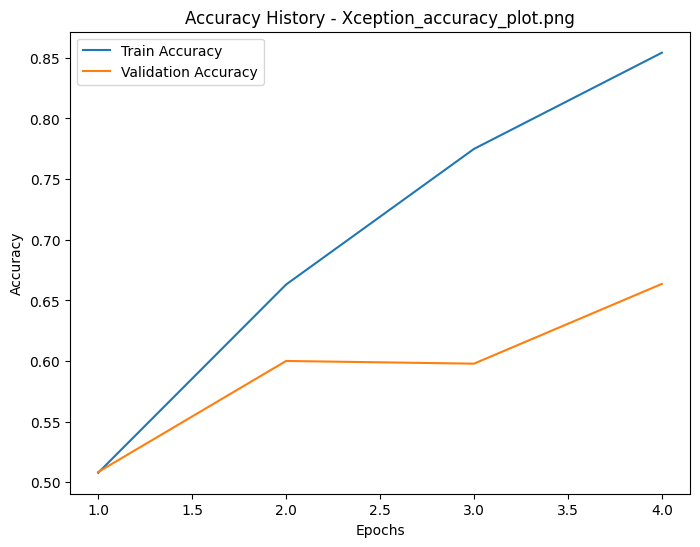

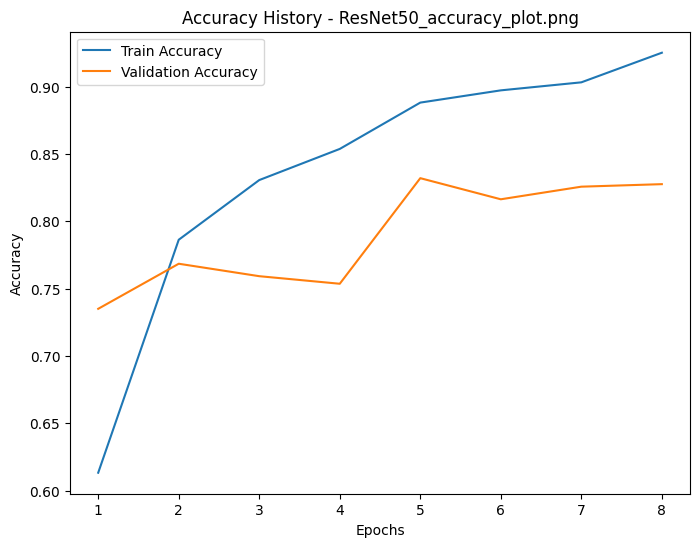

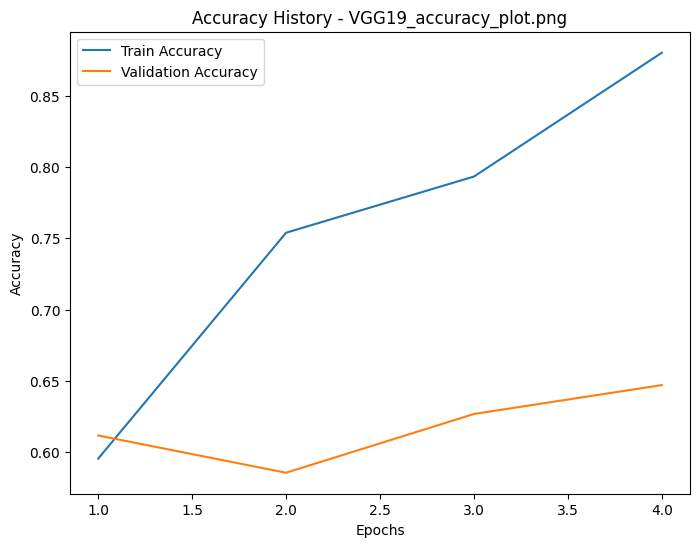

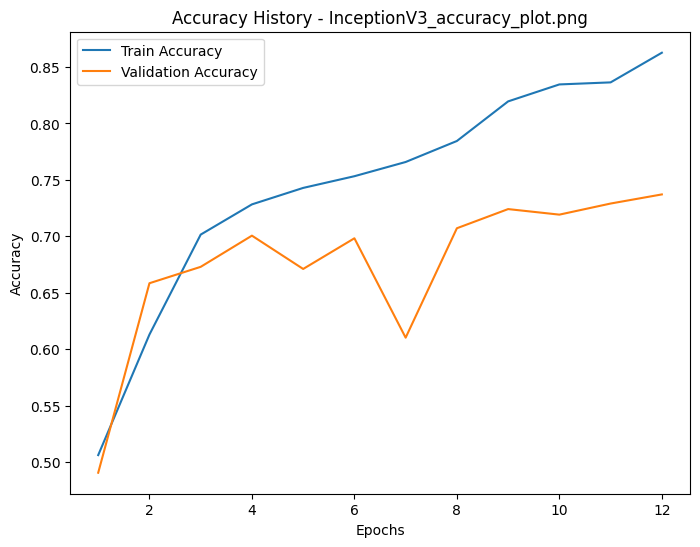

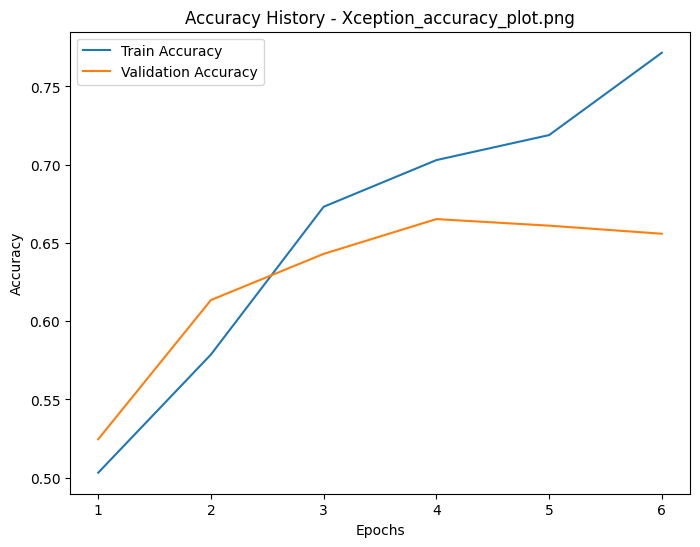

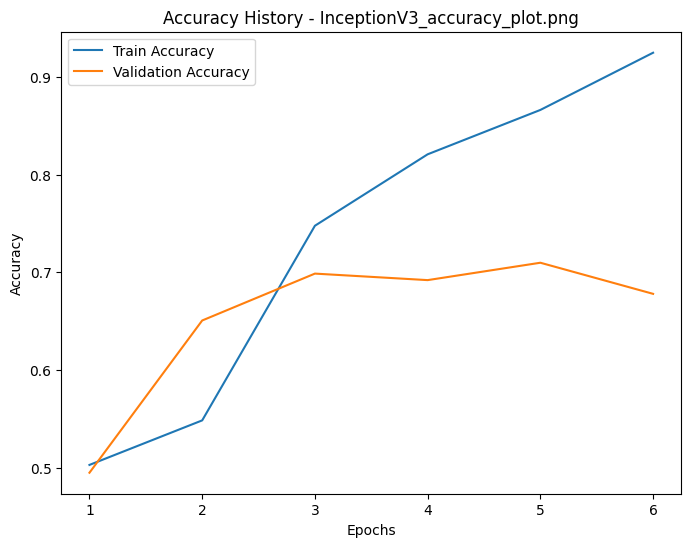

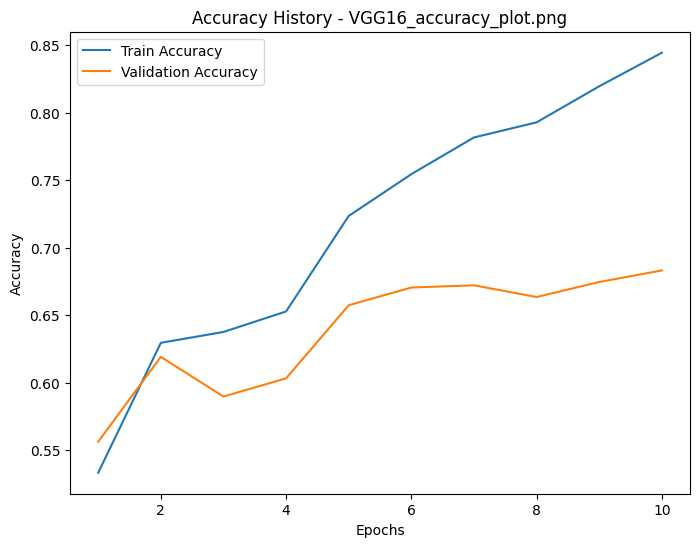

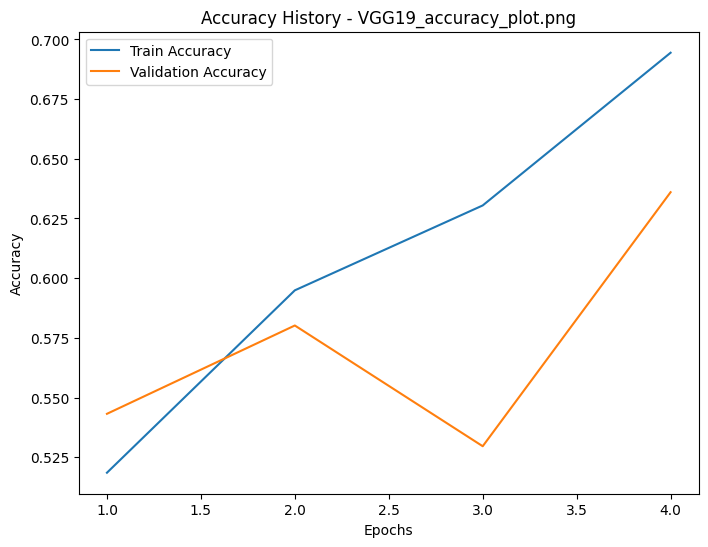

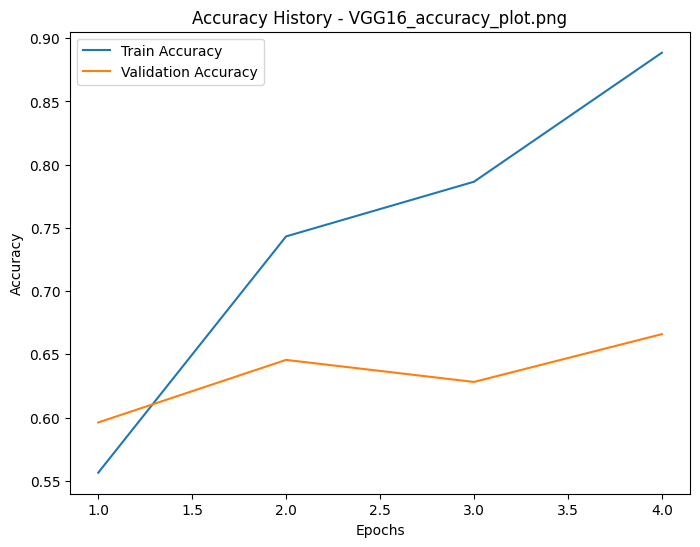

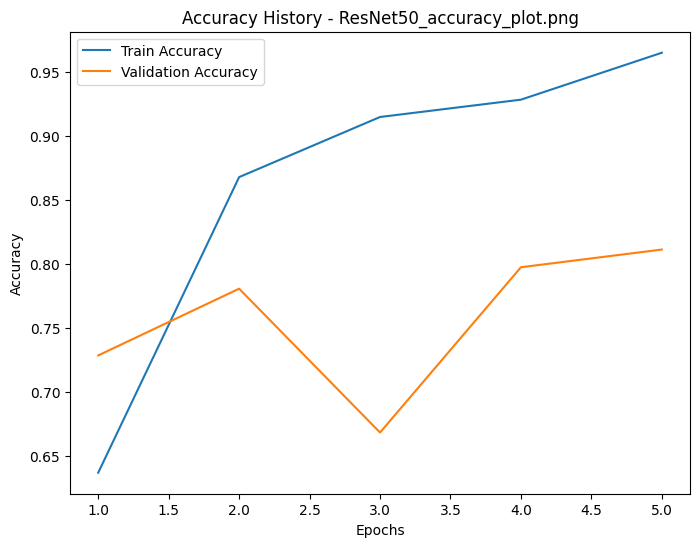

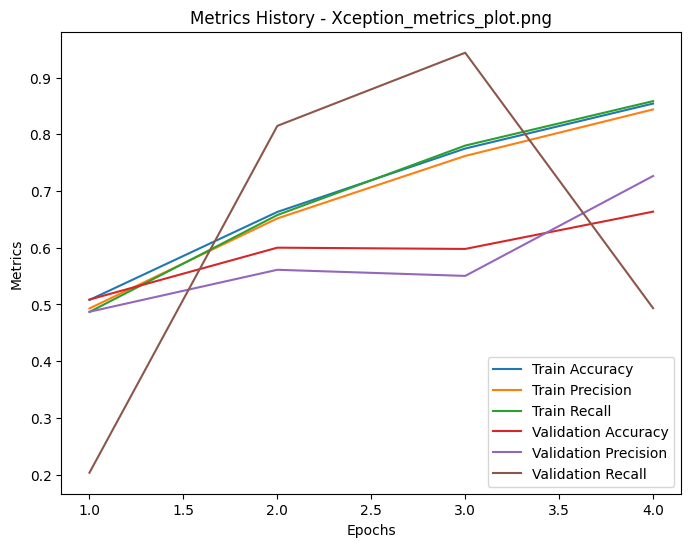

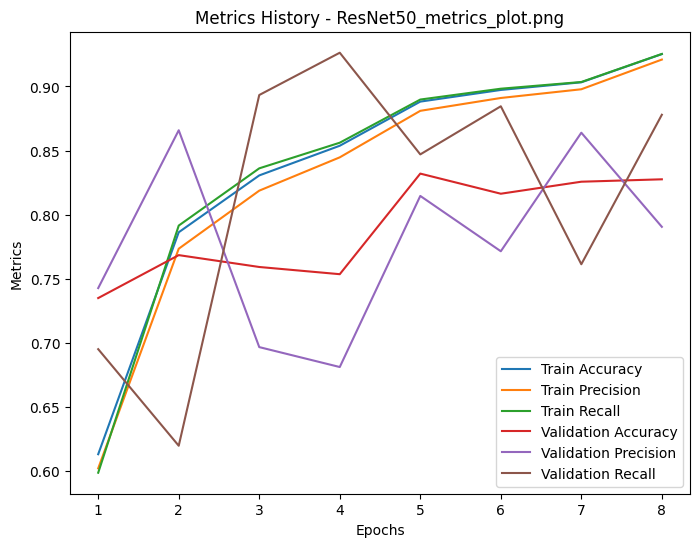

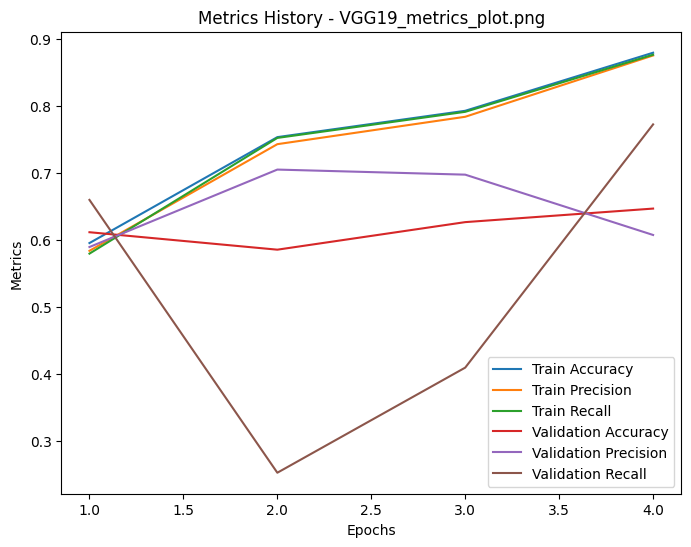

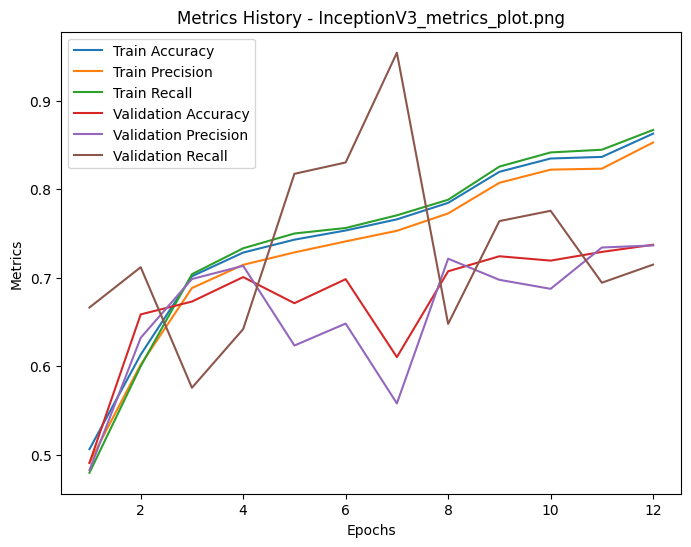

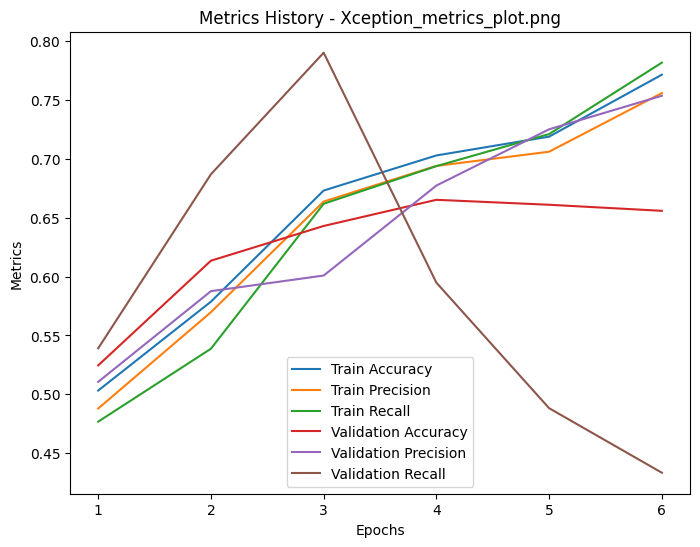

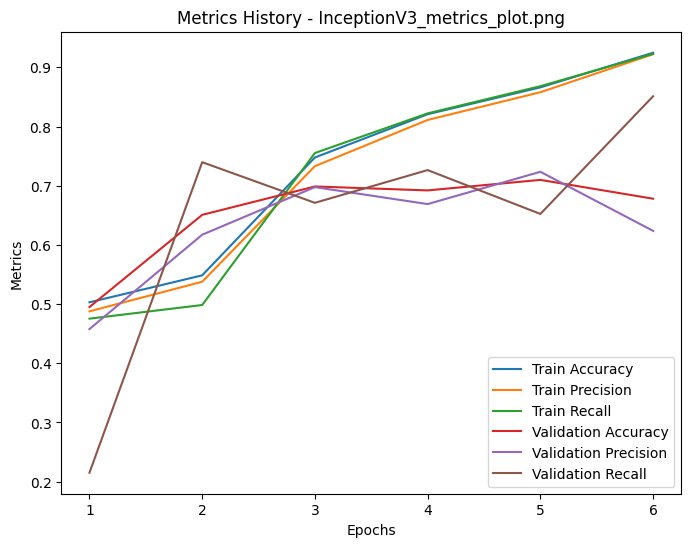

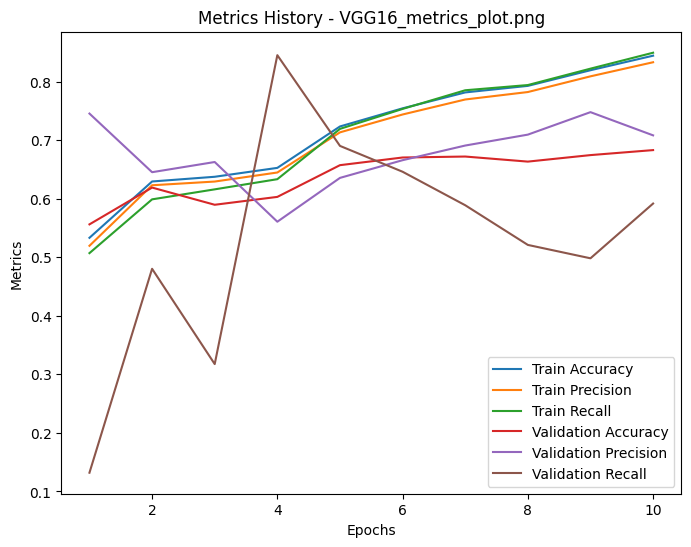

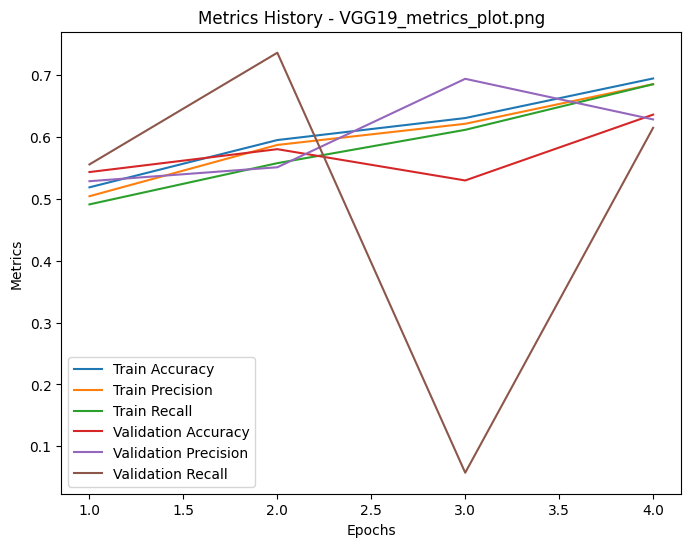

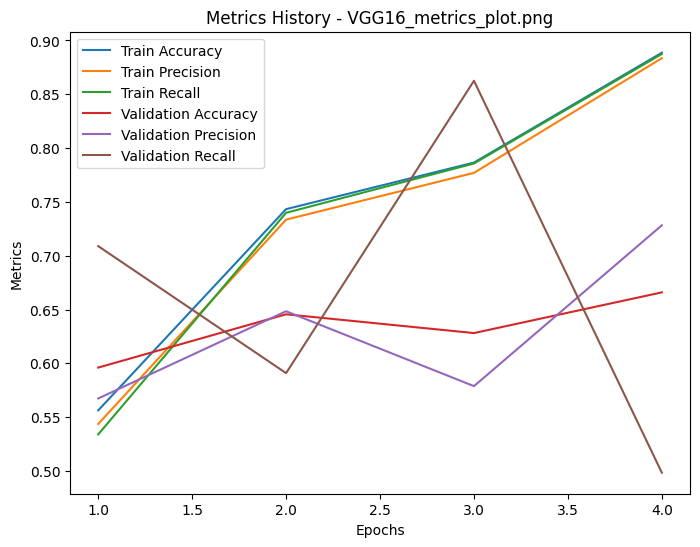

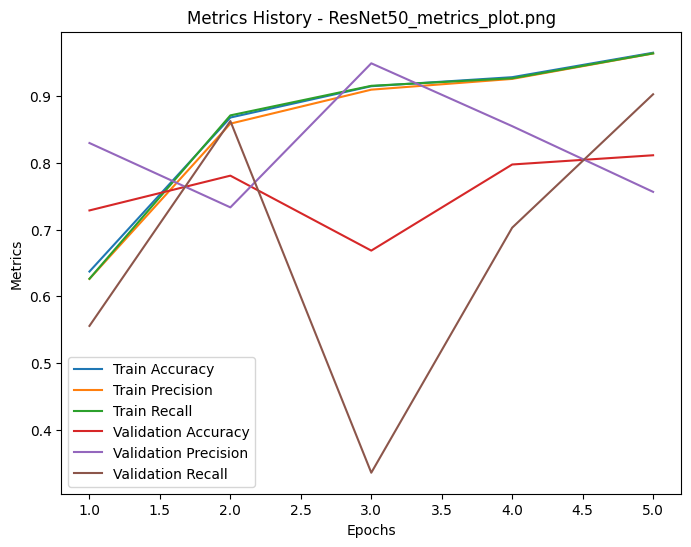

In [5]:
# Experiment ID:BMS-0001
experimentId = "BMS-0001"

# Load Directories (Leave alone unless specifying a different dataset)
experiment_train_directory = train_directory
experiment_test_directory = test_directory
experiment_directory = f"{experiment_base_directory}/{experimentId}"
experiment_results_directory = f"{experiment_directory}/results"
experiment_models_directory = f"{experiment_directory}/models"

# Create directories if they don't exist
os.makedirs(name=experiment_directory, exist_ok=True)
os.makedirs(name=experiment_models_directory, exist_ok=True)
os.makedirs(name=experiment_results_directory, exist_ok=True)

# Declare lists for report generation
accuracy_report = []

# Declare Test Configurations
test_configurations = [
    [Xception, xception_preprocess_input, 32, True],
    [Xception, xception_preprocess_input, 32, False],
    [InceptionV3, inception_v3_preprocess_input, 32, True],
    [InceptionV3, inception_v3_preprocess_input, 32, False],
    [ResNet50, resnet50_preprocess_input, 32, True],
    [ResNet50, resnet50_preprocess_input, 32, False],
    [VGG16, vgg16_preprocess_input, 16, True],
    [VGG16, vgg16_preprocess_input, 16, False],
    [VGG19, vgg19_preprocess_input, 16, True],
    [VGG19, vgg19_preprocess_input, 16, False],
]

# Define Early Stopping Callback
early_stopping = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=3
)

# Define Reduce Learning Rate on Plateau Callback
lr_reducer = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=2,
    verbose=1,
)

# Loop through all combinations of models and trainable layers
for pretrained_model, preprocessing_function, batchSize, isAugmented in test_configurations:
    K.clear_session()

    # Setup Model Check Pointing
    nameSuffix = 'augmented' if isAugmented == True else 'not_augmented'
    model_checkpoint = ModelCheckpoint(
        filepath=f"{experiment_models_directory}/{pretrained_model.__name__}_model_{nameSuffix}.h5",
        monitor='val_loss',
        mode='min',
        verbose=1,
        save_best_only=True
    )

    # Create a dataset and preprocess images to suit base model
    train_ds, val_ds = create_train_val_datasets(preprocessing_function, experiment_train_directory, batch_size=batchSize, augment_data=isAugmented)
    test_ds = create_test_dataset(preprocessing_function, experiment_test_directory, batch_size=batchSize)

    # Create Input Layer
    inputs = Input(shape=(299, 299, 3))

    # Create the base model from the pre-trained model
    base_model = pretrained_model(
        weights="imagenet", 
        include_top=False,
        input_tensor=inputs)

    # Base Model Frozen
    base_model.trainable = False

    # Add a classification head
    top_model = base_model(inputs, training=False)
    top_model = Conv2D(2048, (3, 3), padding='same')(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Activation('relu')(top_model)
    top_model = MaxPooling2D(pool_size=(2, 2))(top_model)

    top_model = Conv2D(2048, (3, 3), padding='same')(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Activation('relu')(top_model)
    top_model = MaxPooling2D(pool_size=(2, 2))(top_model)

    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Dropout(0.8)(top_model)

    top_model = Dense(1024, activation='relu')(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Dropout(0.8)(top_model)

    top_model = Dense(1, activation='sigmoid')(top_model)

    model = Model(inputs=base_model.input, outputs=top_model)

    # Compile the model
    model.compile(
        optimizer=Adam(0.01),  
        loss=BinaryCrossentropy(from_logits=False),
        metrics=[BinaryAccuracy(), Precision(), Recall(), AUC()]
    )

    # Create Model Image
    create_model_image(model, experiment_models_directory, name = f'{pretrained_model.__name__}_model', extension = 'png')

    # Start Timer to measure processing time 
    start_time = time.time()

    # Train the model but first clear history (Required to append results without errors)
    history = model.fit(
        train_ds, 
        steps_per_epoch=train_ds.samples // train_ds.batch_size,
        epochs=15, 
        validation_data=test_ds,
        validation_steps=test_ds.samples // test_ds.batch_size,
        callbacks = [early_stopping, lr_reducer, model_checkpoint]
    )

    # End Timer and calculate processing time
    end_time = time.time()
    processing_time = end_time - start_time

    # Evaluate the model
    evaluate = model.evaluate(test_ds, steps = test_ds.samples // test_ds.batch_size, verbose=1)

    # Append results to accuracy_test list
    history_key = list(history.history.keys()) # As names of metric names can be dynamic, we need to get the keys of the history object
    accuracy_report.append({
        'Base Model': pretrained_model.__name__,
        'data_augmentation': isAugmented,
        'duration': round(processing_time, 3),
        'test_accuracy': round(evaluate[1], 3),
        'test_precision': round(evaluate[2], 3),
        'test_recall': round(evaluate[3], 3),
        'test_loss': round(evaluate[0], 3),
        'train_accuracy': round(history.history[history_key[1]][-1],3),
        'train_precision': round(history.history[history_key[2]][-1],3),
        'train_recall': round(history.history[history_key[3]][-1],3),
        'train_auc' : round(history.history[history_key[4]][-1],3),
        'train_loss': round(history.history[history_key[0]][-1],3),
        'val_accuracy': round(history.history[history_key[6]][-1],3),
        'val_precision': round(history.history[history_key[7]][-1],3),
        'val_recall': round(history.history[history_key[8]][-1],3),
        'val_auc' : round(history.history[history_key[9]][-1],3),
        'val_loss': round(history.history[history_key[5]][-1],3)
    })

    epochs_report = pd.DataFrame(history.history)
    epochs_report.to_csv(f"{experiment_results_directory}/{pretrained_model.__name__}_{nameSuffix}_epochs_report.csv", index=False)

# Create DataFrame with accuracy score and export as .csv
accuracy_test_results = pd.DataFrame(accuracy_report)
accuracy_test_results.to_csv(f'{experiment_results_directory}/accuracy_test_results.csv', index=False)

# Generate graphs from epochs_reports.csv and output to results folder.
create_accuracy_plots(f"{experiment_results_directory}")
create_all_metrics_plots(f"{experiment_results_directory}")

----
## Experiment #BMS-0002 | Xception Fine-Tuning
**Experiment ID:** #BMS-0002  
**Experiment Description:**  Continuation of experiment BMS-0001, We load the pretrained models from the previous experiment and unfreeze the last 15 layers of the base model. The experiment we use Xception with data augmentation enabled.
  
**Experiment Outcome:**  
**Next Test:** 


Found 38634 images belonging to 2 classes.
Found 9657 images belonging to 2 classes.
Found 8557 images belonging to 2 classes.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 conv2d_4 (Conv2D)           (None, 10, 10, 2048)      37750784  
                                                                 
 batch_normalization_4 (Batc  (None, 10, 10, 2048)     8192      
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 10, 10, 2048)      0         
                                                                 


2023-06-03 09:47:07.029143: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1207/1207 [==============================] - ETA: 0s - loss: 0.4661 - binary_accuracy: 0.7798 - precision: 0.7823 - recall: 0.7571 - auc: 0.8627

2023-06-03 09:54:36.246151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.41530, saving model to ../experiments/base-model-selection/BMS-0002/models/Xception_model_augmented_vl.h5

Epoch 1: val_binary_accuracy improved from -inf to 0.81191, saving model to ../experiments/base-model-selection/BMS-0002/models/Xception_model_augmented_ba.h5
1207/1207 [==============================] - 478s 388ms/step - loss: 0.4661 - binary_accuracy: 0.7798 - precision: 0.7823 - recall: 0.7571 - auc: 0.8627 - val_loss: 0.4153 - val_binary_accuracy: 0.8119 - val_precision: 0.7902 - val_recall: 0.8346 - val_auc: 0.8944 - lr: 1.0000e-04
Epoch 2/50
1207/1207 [==============================] - ETA: 0s - loss: 0.2985 - binary_accuracy: 0.8763 - precision: 0.8665 - recall: 0.8809 - auc: 0.9457
Epoch 2: val_loss did not improve from 0.41530

Epoch 2: val_binary_accuracy did not improve from 0.81191
1207/1207 [==============================] - 456s 378ms/step - loss: 0.2985 - binary_accuracy: 0.8763 - precision: 0.8665 - recall: 0.8809 - auc: 0.

2023-06-03 11:12:03.505597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


267/267 [==============================] - 25s 95ms/step - loss: 0.5412 - binary_accuracy: 0.8537 - precision: 0.7851 - recall: 0.9622 - auc: 0.9389


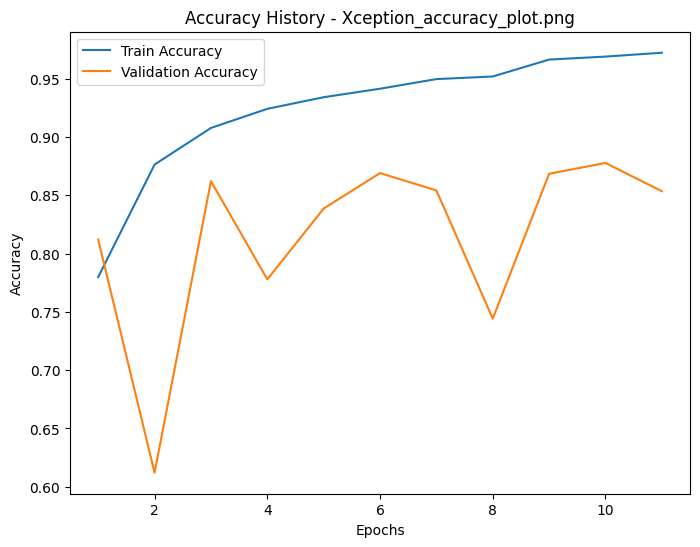

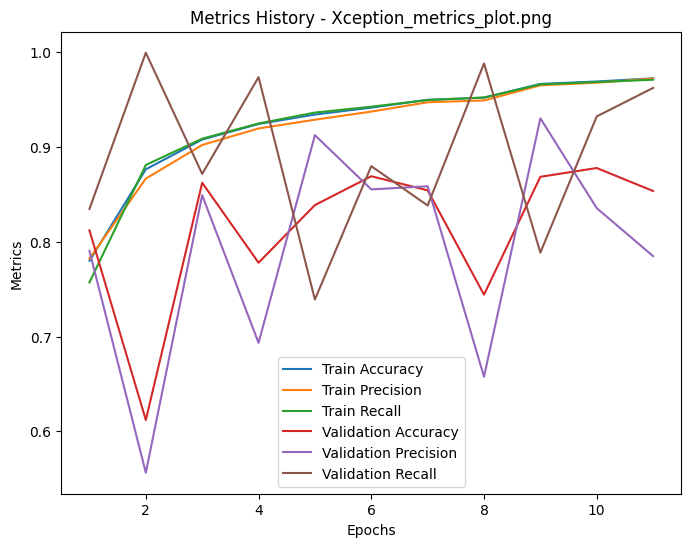

In [7]:
# Experiment ID:BMS-0002
experimentId = "BMS-0002"

# Load Directories (Leave alone unless specifying a different dataset)
experiment_train_directory = train_directory
experiment_test_directory = test_directory
experiment_directory = f"{experiment_base_directory}/{experimentId}"
experiment_results_directory = f"{experiment_directory}/results"
experiment_models_directory = f"{experiment_directory}/models"
experiment_load_model_directory = "../experiments/base-model-selection/BMS-0001/models"

# Create directories if they don't exist
os.makedirs(name=experiment_directory, exist_ok=True)
os.makedirs(name=experiment_models_directory, exist_ok=True)
os.makedirs(name=experiment_results_directory, exist_ok=True)

# Declare lists for report generation
accuracy_report = []

# Declare Test Configurations
test_configurations = [
    [Xception, xception_preprocess_input, 32, True],
]

# Declare accuracy_test list
accuracy_test = []

# Define Early Stopping Callback
early_stopping = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=8
)

# Define Reduce Learning Rate on Plateau Callback
lr_reducer = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    verbose=1,
)

# Loop through all combinations of models and trainable layers
for pretrained_model, preprocessing_function, batch_size, is_augmented in test_configurations:
    # Clear Session
    K.clear_session()
    
    # Setup Model Check Pointing
    
    nameSuffix = 'augmented' if is_augmented == True else 'not_augmented'
    model_checkpoint_vl = ModelCheckpoint(
        filepath=f"{experiment_models_directory}/{pretrained_model.__name__}_model_{nameSuffix}_vl.h5",
        monitor='val_loss',
        mode='min',
        verbose=1,
        save_best_only=True
    )
    
    model_checkpoint_ba = ModelCheckpoint(
        filepath=f"{experiment_models_directory}/{pretrained_model.__name__}_model_{nameSuffix}_ba.h5",
        monitor='val_binary_accuracy',
        mode='max',
        verbose=1,
        save_best_only=True
    )
    
    # Create a dataset and preprocess images to suit base model
    train_ds, val_ds = create_train_val_datasets(preprocessing_function, experiment_train_directory, batch_size=batch_size, augment_data=is_augmented)
    test_ds = create_test_dataset(preprocessing_function, experiment_test_directory, batch_size=batch_size)

    # Create Input Layer
    inputs = Input(shape=(299, 299, 3))


    #####################################################################################################################################
    # Load Previous Model and Weights
    #####################################################################################################################################

    # Load Model
    model = keras.models.load_model(
        f"{experiment_load_model_directory}/{pretrained_model.__name__}_model_{nameSuffix}.h5",
    )
    
    # Create Input Layer
    inputs = Input(shape=(299, 299, 3))

    # Base model is the second layer in the model
    base_model = model.layers[1]

    # Make Base Model Trainable
    base_model.trainable = True

    # Freeze the base model (do not train everything but last 15 layers)
    for layer in base_model.layers[:-15]:
        layer.trainable = False

    # Hookup Previous Model Layers to New Model
    inputs = keras.Input(shape=(299, 299, 3))
    x = base_model(inputs, training=False)
    
    # Traverse the layers and connect them
    for layer in model.layers[2:]:
        x = layer(x)
    
    # Define the model
    model = keras.Model(inputs=inputs, outputs=x)

    model.summary()
    # Compile the model
    model.compile(
        optimizer=Adam(1e-4),  
        loss=BinaryCrossentropy(from_logits=False),
        metrics=[BinaryAccuracy(), Precision(), Recall(), AUC()]
    )
    
    #####################################################################################################################################
    # Begin Fine Tuning Entire Model
    #####################################################################################################################################
    
    # Start Timer to measure processing time 
    start_time = time.time()

    # Train the model
    history = model.fit(
        train_ds, 
        steps_per_epoch=train_ds.samples // train_ds.batch_size,
        epochs=50, 
        validation_data=test_ds,
        validation_steps=test_ds.samples // test_ds.batch_size,
        callbacks = [early_stopping, lr_reducer, model_checkpoint_vl, model_checkpoint_ba]
    )
    
    # End Timer and calculate processing time
    end_time = time.time()
    processing_time = end_time - start_time

    # Evaluate the model
    evaluate = model.evaluate(test_ds, steps = test_ds.samples // test_ds.batch_size, verbose=1)

    # Append results to accuracy_test list
    history_key = list(history.history.keys()) # As names of metric names can be dynamic, we need to get the keys of the history object
    accuracy_test.append({
        'Base Model': pretrained_model.__name__,
        'duration': round(processing_time, 3),
        'test_accuracy': round(evaluate[1], 3),
        'test_precision': round(evaluate[2], 3),
        'test_recall': round(evaluate[3], 3),
        'test_loss': round(evaluate[0], 3),
        'train_accuracy': round(history.history[history_key[1]][-1],3),
        'train_precision': round(history.history[history_key[2]][-1],3),
        'train_recall': round(history.history[history_key[3]][-1],3),
        'train_auc' : round(history.history[history_key[4]][-1],3),
        'train_loss': round(history.history[history_key[0]][-1],3),
        'val_accuracy': round(history.history[history_key[6]][-1],3),
        'val_precision': round(history.history[history_key[7]][-1],3),
        'val_recall': round(history.history[history_key[8]][-1],3),
        'val_auc' : round(history.history[history_key[9]][-1],3),
        'val_loss': round(history.history[history_key[5]][-1],3)
    })
    
    epochs_report = pd.DataFrame(history.history)
    epochs_report.to_csv(f"{experiment_results_directory}/{pretrained_model.__name__}_epochs_report.csv", index=False)
    
    model.save(f"{experiment_models_directory}/{pretrained_model.__name__}_finetuned_model_{nameSuffix}.h5")

# Create DataFrame with accuracy score and export as .csv
accuracy_test_results = pd.DataFrame(accuracy_test)
accuracy_test_results.to_csv(f'{experiment_results_directory}/accuracy_test_results.csv', index=False)

# Generate graphs from epochs_reports.csv and output to results folder.
create_accuracy_plots(f"{experiment_results_directory}")
create_all_metrics_plots(f"{experiment_results_directory}")

----
## Experiment #BMS-0003 | InceptionV3 Fine-Tuning
**Experiment ID:** #BMS-0003  
**Experiment Description:**  Continuation of experiment BMS-0001, We load the pretrained models from the previous experiment and unfreeze the last 15 layers of the base model. The experiment we use Inception with data augmentation enabled.


Found 38634 images belonging to 2 classes.
Found 9657 images belonging to 2 classes.
Found 8557 images belonging to 2 classes.


2023-06-02 16:50:44.163040: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-02 16:50:44.163387: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-02 16:50:44.163667: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 conv2d_94 (Conv2D)          (None, 8, 8, 2048)        37750784  
                                                                 
 batch_normalization_94 (Bat  (None, 8, 8, 2048)       8192      
 chNormalization)                                                
                                                                 
 activation_94 (Activation)  (None, 8, 8, 2048)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 4, 4, 2048)       0         
 2D)                                                         

2023-06-02 16:50:49.026601: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-02 16:50:52.727906: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-06-02 16:50:56.113919: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-06-02 16:50:56.132936: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x55d8e6d80880 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-02 16:50:56.132952: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2023-06-02 16:50:56.14887

1207/1207 [==============================] - ETA: 0s - loss: 0.3621 - binary_accuracy: 0.8427 - precision: 0.8310 - recall: 0.8483 - auc: 0.9188

2023-06-02 16:58:24.532757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.62672, saving model to ../experiments/base-model-selection/BMS-0003/models/InceptionV3_model_augmented_vl.h5

Epoch 1: val_binary_accuracy improved from -inf to 0.72706, saving model to ../experiments/base-model-selection/BMS-0003/models/InceptionV3_model_augmented_ba.h5
1207/1207 [==============================] - 483s 392ms/step - loss: 0.3621 - binary_accuracy: 0.8427 - precision: 0.8310 - recall: 0.8483 - auc: 0.9188 - val_loss: 0.6267 - val_binary_accuracy: 0.7271 - val_precision: 0.6890 - val_recall: 0.7988 - val_auc: 0.8099 - lr: 1.0000e-04
Epoch 2/50
1207/1207 [==============================] - ETA: 0s - loss: 0.3336 - binary_accuracy: 0.8573 - precision: 0.8442 - recall: 0.8658 - auc: 0.9314
Epoch 2: val_loss improved from 0.62672 to 0.60210, saving model to ../experiments/base-model-selection/BMS-0003/models/InceptionV3_model_augmented_vl.h5

Epoch 2: val_binary_accuracy improved from 0.72706 to 0.73525, saving model to ../experiments

2023-06-02 18:30:44.652762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


267/267 [==============================] - 21s 78ms/step - loss: 0.6400 - binary_accuracy: 0.7618 - precision: 0.7893 - recall: 0.6956 - auc: 0.8468


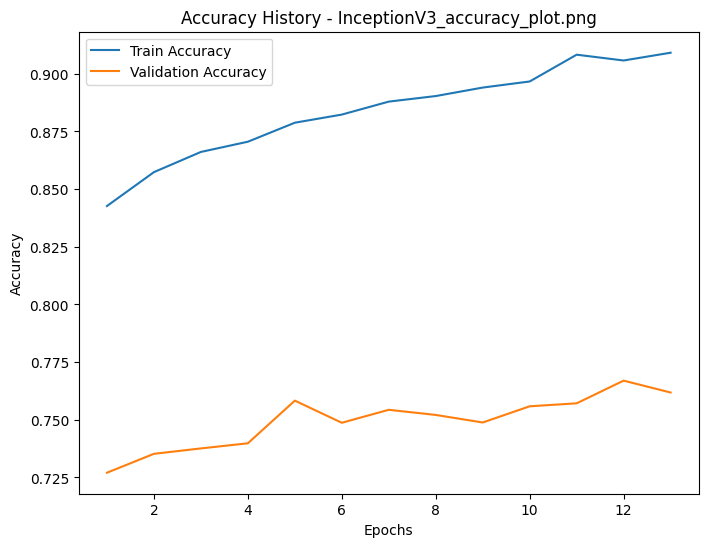

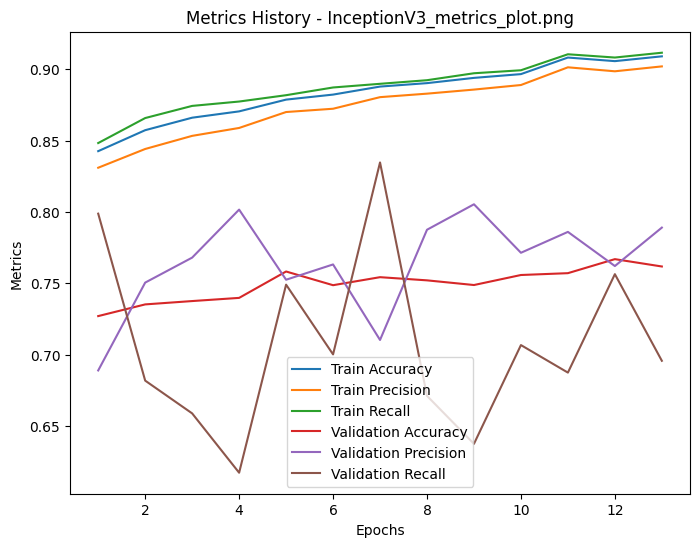

In [5]:
# Experiment ID:BMS-0003
experimentId = "BMS-0003"

# Load Directories (Leave alone unless specifying a different dataset)
experiment_train_directory = train_directory
experiment_test_directory = test_directory
experiment_directory = f"{experiment_base_directory}/{experimentId}"
experiment_results_directory = f"{experiment_directory}/results"
experiment_models_directory = f"{experiment_directory}/models"
experiment_load_model_directory = "../experiments/base-model-selection/BMS-0001/models"

# Create directories if they don't exist
os.makedirs(name=experiment_directory, exist_ok=True)
os.makedirs(name=experiment_models_directory, exist_ok=True)
os.makedirs(name=experiment_results_directory, exist_ok=True)

# Declare lists for report generation
accuracy_report = []

# Declare Test Configurations
test_configurations = [
    [InceptionV3, inception_v3_preprocess_input, 32, True],
]

# Declare accuracy_test list
accuracy_test = []

# Define Early Stopping Callback
early_stopping = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=8
)

# Define Reduce Learning Rate on Plateau Callback
lr_reducer = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    verbose=1,
)

# Loop through all combinations of models and trainable layers
for pretrained_model, preprocessing_function, batch_size, is_augmented in test_configurations:
    # Clear Session
    K.clear_session()
    
    # Setup Model Check Pointing
    
    nameSuffix = 'augmented' if is_augmented == True else 'not_augmented'
    model_checkpoint_vl = ModelCheckpoint(
        filepath=f"{experiment_models_directory}/{pretrained_model.__name__}_model_{nameSuffix}_vl.h5",
        monitor='val_loss',
        mode='min',
        verbose=1,
        save_best_only=True
    )
    
    model_checkpoint_ba = ModelCheckpoint(
        filepath=f"{experiment_models_directory}/{pretrained_model.__name__}_model_{nameSuffix}_ba.h5",
        monitor='val_binary_accuracy',
        mode='max',
        verbose=1,
        save_best_only=True
    )
    
    # Create a dataset and preprocess images to suit base model
    train_ds, val_ds = create_train_val_datasets(preprocessing_function, experiment_train_directory, batch_size=batch_size, augment_data=is_augmented)
    test_ds = create_test_dataset(preprocessing_function, experiment_test_directory, batch_size=batch_size)

    # Create Input Layer
    inputs = Input(shape=(299, 299, 3))


    #####################################################################################################################################
    # Load Previous Model and Weights
    #####################################################################################################################################

    # Load Model
    model = keras.models.load_model(
        f"{experiment_load_model_directory}/{pretrained_model.__name__}_model_{nameSuffix}.h5",
    )
    
    # Create Input Layer
    inputs = Input(shape=(299, 299, 3))

    # Base model is the second layer in the model
    base_model = model.layers[1]

    # Make Base Model Trainable
    base_model.trainable = True

    # Freeze the base model (do not train everything but last 15 layers)
    for layer in base_model.layers[:-15]:
        layer.trainable = False

    # Hookup Previous Model Layers to New Model
    inputs = keras.Input(shape=(299, 299, 3))
    x = base_model(inputs, training=False)
    
    # Traverse the layers and connect them
    for layer in model.layers[2:]:
        x = layer(x)
    
    # Define the model
    model = keras.Model(inputs=inputs, outputs=x)

    model.summary()
    # Compile the model
    model.compile(
        optimizer=Adam(1e-4),  
        loss=BinaryCrossentropy(from_logits=False),
        metrics=[BinaryAccuracy(), Precision(), Recall(), AUC()]
    )
    
    #####################################################################################################################################
    # Begin Fine Tuning Entire Model
    #####################################################################################################################################
    
    # Start Timer to measure processing time 
    start_time = time.time()

    # Train the model
    history = model.fit(
        train_ds, 
        steps_per_epoch=train_ds.samples // train_ds.batch_size,
        epochs=50, 
        validation_data=test_ds,
        validation_steps=test_ds.samples // test_ds.batch_size,
        callbacks = [early_stopping, lr_reducer, model_checkpoint_vl, model_checkpoint_ba]
    )
    
    # End Timer and calculate processing time
    end_time = time.time()
    processing_time = end_time - start_time

    # Evaluate the model
    evaluate = model.evaluate(test_ds, steps = test_ds.samples // test_ds.batch_size, verbose=1)

    # Append results to accuracy_test list
    history_key = list(history.history.keys()) # As names of metric names can be dynamic, we need to get the keys of the history object
    accuracy_test.append({
        'Base Model': pretrained_model.__name__,
        'duration': round(processing_time, 3),
        'test_accuracy': round(evaluate[1], 3),
        'test_precision': round(evaluate[2], 3),
        'test_recall': round(evaluate[3], 3),
        'test_loss': round(evaluate[0], 3),
        'train_accuracy': round(history.history[history_key[1]][-1],3),
        'train_precision': round(history.history[history_key[2]][-1],3),
        'train_recall': round(history.history[history_key[3]][-1],3),
        'train_auc' : round(history.history[history_key[4]][-1],3),
        'train_loss': round(history.history[history_key[0]][-1],3),
        'val_accuracy': round(history.history[history_key[6]][-1],3),
        'val_precision': round(history.history[history_key[7]][-1],3),
        'val_recall': round(history.history[history_key[8]][-1],3),
        'val_auc' : round(history.history[history_key[9]][-1],3),
        'val_loss': round(history.history[history_key[5]][-1],3)
    })
    
    epochs_report = pd.DataFrame(history.history)
    epochs_report.to_csv(f"{experiment_results_directory}/{pretrained_model.__name__}_epochs_report.csv", index=False)
    
    model.save(f"{experiment_models_directory}/{pretrained_model.__name__}_finetuned_model_{nameSuffix}.h5")

# Create DataFrame with accuracy score and export as .csv
accuracy_test_results = pd.DataFrame(accuracy_test)
accuracy_test_results.to_csv(f'{experiment_results_directory}/accuracy_test_results.csv', index=False)

# Generate graphs from epochs_reports.csv and output to results folder.
create_accuracy_plots(f"{experiment_results_directory}")
create_all_metrics_plots(f"{experiment_results_directory}")

----
## Experiment #BMS-0004 | Resnet50 Fine-Tuning
**Experiment ID:** #BMS-0004  
**Experiment Description:**  Continuation of experiment BMS-0001, We load the pretrained models from the previous experiment and unfreeze the last 15 layers of the base model. The experiment we use Resnet with data augmentation enabled.


Found 38634 images belonging to 2 classes.
Found 9657 images belonging to 2 classes.
Found 8557 images belonging to 2 classes.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 10, 10, 2048)      23587712  
                                                                 
 conv2d (Conv2D)             (None, 10, 10, 2048)      37750784  
                                                                 
 batch_normalization (BatchN  (None, 10, 10, 2048)     8192      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 10, 10, 2048)      0         
                                                                 


2023-06-01 20:51:58.470927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


2414/2414 [==============================] - ETA: 0s - loss: 0.2788 - binary_accuracy: 0.8862 - precision: 0.8823 - recall: 0.8833 - auc: 0.9526

2023-06-01 20:59:07.196358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.39792, saving model to ../experiments/base-model-selection/BMS-0004/models/ResNet50_model_augmented_vl.h5

Epoch 1: val_binary_accuracy improved from -inf to 0.83240, saving model to ../experiments/base-model-selection/BMS-0004/models/ResNet50_model_augmented_ba.h5
2414/2414 [==============================] - 463s 190ms/step - loss: 0.2788 - binary_accuracy: 0.8862 - precision: 0.8823 - recall: 0.8833 - auc: 0.9526 - val_loss: 0.3979 - val_binary_accuracy: 0.8324 - val_precision: 0.7957 - val_recall: 0.8819 - val_auc: 0.9195 - lr: 1.0000e-04
Epoch 2/50
2414/2414 [==============================] - ETA: 0s - loss: 0.2377 - binary_accuracy: 0.9046 - precision: 0.8990 - recall: 0.9052 - auc: 0.9652
Epoch 2: val_loss improved from 0.39792 to 0.38159, saving model to ../experiments/base-model-selection/BMS-0004/models/ResNet50_model_augmented_vl.h5

Epoch 2: val_binary_accuracy improved from 0.83240 to 0.84071, saving model to ../experiments/base-mod

2023-06-01 22:08:43.864377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


534/534 [==============================] - 32s 61ms/step - loss: 0.4359 - binary_accuracy: 0.8480 - precision: 0.8404 - recall: 0.8483 - auc: 0.9232


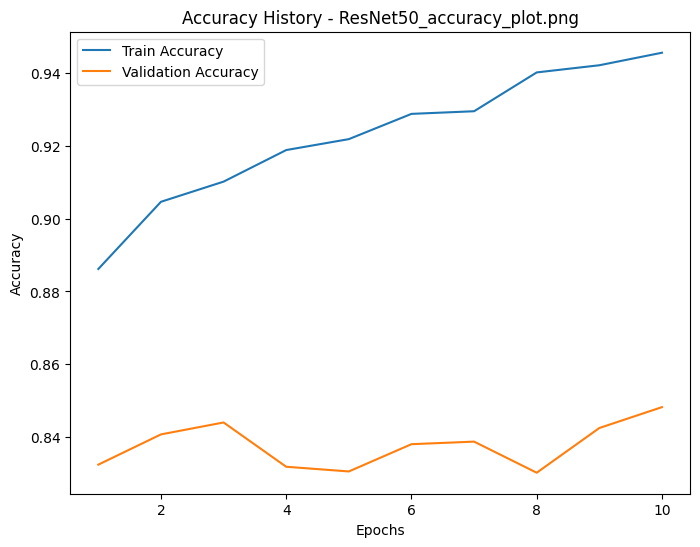

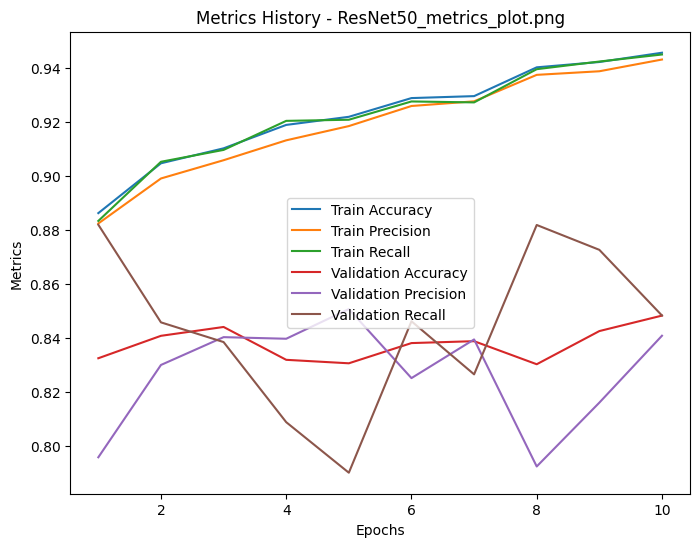

In [13]:
# Experiment ID:BMS-0004
experimentId = "BMS-0004"

# Load Directories (Leave alone unless specifying a different dataset)
experiment_train_directory = train_directory
experiment_test_directory = test_directory
experiment_directory = f"{experiment_base_directory}/{experimentId}"
experiment_results_directory = f"{experiment_directory}/results"
experiment_models_directory = f"{experiment_directory}/models"
experiment_load_model_directory = "../experiments/base-model-selection/BMS-0001/models"

# Create directories if they don't exist
os.makedirs(name=experiment_directory, exist_ok=True)
os.makedirs(name=experiment_models_directory, exist_ok=True)
os.makedirs(name=experiment_results_directory, exist_ok=True)

# Declare lists for report generation
accuracy_report = []

# Declare Test Configurations
test_configurations = [
    [ResNet50, resnet50_preprocess_input, 16, True],
]

# Declare accuracy_test list
accuracy_test = []

# Define Early Stopping Callback
early_stopping = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=8
)

# Define Reduce Learning Rate on Plateau Callback
lr_reducer = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    verbose=1,
)

# Loop through all combinations of models and trainable layers
for pretrained_model, preprocessing_function, batch_size, is_augmented in test_configurations:
    # Clear Session
    K.clear_session()
    
    # Setup Model Check Pointing
    
    nameSuffix = 'augmented' if is_augmented == True else 'not_augmented'
    model_checkpoint_vl = ModelCheckpoint(
        filepath=f"{experiment_models_directory}/{pretrained_model.__name__}_model_{nameSuffix}_vl.h5",
        monitor='val_loss',
        mode='min',
        verbose=1,
        save_best_only=True
    )
    
    model_checkpoint_ba = ModelCheckpoint(
        filepath=f"{experiment_models_directory}/{pretrained_model.__name__}_model_{nameSuffix}_ba.h5",
        monitor='val_binary_accuracy',
        mode='max',
        verbose=1,
        save_best_only=True
    )
    
    # Create a dataset and preprocess images to suit base model
    train_ds, val_ds = create_train_val_datasets(preprocessing_function, experiment_train_directory, batch_size=batch_size, augment_data=is_augmented)
    test_ds = create_test_dataset(preprocessing_function, experiment_test_directory, batch_size=batch_size)

    # Create Input Layer
    inputs = Input(shape=(299, 299, 3))


    #####################################################################################################################################
    # Load Previous Model and Weights
    #####################################################################################################################################

    # Load Model
    model = keras.models.load_model(
        f"{experiment_load_model_directory}/{pretrained_model.__name__}_model_{nameSuffix}.h5",
    )
    
    # Create Input Layer
    inputs = Input(shape=(299, 299, 3))

    # Base model is the second layer in the model
    base_model = model.layers[1]

    # Make Base Model Trainable
    base_model.trainable = True

    # Freeze the base model (do not train everything but last 15 layers)
    for layer in base_model.layers[:-15]:
        layer.trainable = False

    # Hookup Previous Model Layers to New Model
    inputs = keras.Input(shape=(299, 299, 3))
    x = base_model(inputs, training=False)
    
    # Traverse the layers and connect them
    for layer in model.layers[2:]:
        x = layer(x)
    
    # Define the model
    model = keras.Model(inputs=inputs, outputs=x)

    model.summary()
    # Compile the model
    model.compile(
        optimizer=Adam(1e-4),  
        loss=BinaryCrossentropy(from_logits=False),
        metrics=[BinaryAccuracy(), Precision(), Recall(), AUC()]
    )
    
    #####################################################################################################################################
    # Begin Fine Tuning Entire Model
    #####################################################################################################################################
    
    # Start Timer to measure processing time 
    start_time = time.time()

    # Train the model
    history = model.fit(
        train_ds, 
        steps_per_epoch=train_ds.samples // train_ds.batch_size,
        epochs=50, 
        validation_data=test_ds,
        validation_steps=test_ds.samples // test_ds.batch_size,
        callbacks = [early_stopping, lr_reducer, model_checkpoint_vl, model_checkpoint_ba]
    )
    
    # End Timer and calculate processing time
    end_time = time.time()
    processing_time = end_time - start_time

    # Evaluate the model
    evaluate = model.evaluate(test_ds, steps = test_ds.samples // test_ds.batch_size, verbose=1)

    # Append results to accuracy_test list
    history_key = list(history.history.keys()) # As names of metric names can be dynamic, we need to get the keys of the history object
    accuracy_test.append({
        'Base Model': pretrained_model.__name__,
        'duration': round(processing_time, 3),
        'test_accuracy': round(evaluate[1], 3),
        'test_precision': round(evaluate[2], 3),
        'test_recall': round(evaluate[3], 3),
        'test_loss': round(evaluate[0], 3),
        'train_accuracy': round(history.history[history_key[1]][-1],3),
        'train_precision': round(history.history[history_key[2]][-1],3),
        'train_recall': round(history.history[history_key[3]][-1],3),
        'train_auc' : round(history.history[history_key[4]][-1],3),
        'train_loss': round(history.history[history_key[0]][-1],3),
        'val_accuracy': round(history.history[history_key[6]][-1],3),
        'val_precision': round(history.history[history_key[7]][-1],3),
        'val_recall': round(history.history[history_key[8]][-1],3),
        'val_auc' : round(history.history[history_key[9]][-1],3),
        'val_loss': round(history.history[history_key[5]][-1],3)
    })
    
    epochs_report = pd.DataFrame(history.history)
    epochs_report.to_csv(f"{experiment_results_directory}/{pretrained_model.__name__}_epochs_report.csv", index=False)
    
    model.save(f"{experiment_models_directory}/{pretrained_model.__name__}_finetuned_model_{nameSuffix}.h5")

# Create DataFrame with accuracy score and export as .csv
accuracy_test_results = pd.DataFrame(accuracy_test)
accuracy_test_results.to_csv(f'{experiment_results_directory}/accuracy_test_results.csv', index=False)

# Generate graphs from epochs_reports.csv and output to results folder.
create_accuracy_plots(f"{experiment_results_directory}")
create_all_metrics_plots(f"{experiment_results_directory}")

----
## Experiment #BMS-0005 | VGG16 Fine-Tuning
**Experiment ID:** #BMS-0005  
**Experiment Description:**  Continuation of experiment BMS-0001, We load the pretrained models from the previous experiment and unfreeze the last 15 layers of the base model. The experiment we use VGG16 with data augmentation enabled.


Found 38634 images belonging to 2 classes.
Found 9657 images belonging to 2 classes.
Found 8557 images belonging to 2 classes.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 conv2d (Conv2D)             (None, 9, 9, 2048)        9439232   
                                                                 
 batch_normalization (BatchN  (None, 9, 9, 2048)       8192      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 9, 9, 2048)        0         
                                                                 


2023-06-01 22:09:20.361801: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 608/2414 [======>.......................] - ETA: 5:21 - loss: 0.7680 - binary_accuracy: 0.5731 - precision: 0.5644 - recall: 0.5495 - auc: 0.5963

2023-06-01 22:11:13.493700: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.37GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-06-01 22:11:13.568050: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-06-01 22:11:14.184716: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.17GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


2414/2414 [==============================] - ETA: 0s - loss: 0.7348 - binary_accuracy: 0.5352 - precision: 0.5225 - recall: 0.4910 - auc: 0.5510

2023-06-01 22:16:37.695057: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.68888, saving model to ../experiments/base-model-selection/BMS-0005/models/VGG16_model_augmented_vl.h5

Epoch 1: val_binary_accuracy improved from -inf to 0.52762, saving model to ../experiments/base-model-selection/BMS-0005/models/VGG16_model_augmented_ba.h5
2414/2414 [==============================] - 475s 195ms/step - loss: 0.7348 - binary_accuracy: 0.5352 - precision: 0.5225 - recall: 0.4910 - auc: 0.5510 - val_loss: 0.6889 - val_binary_accuracy: 0.5276 - val_precision: 0.5598 - val_recall: 0.1308 - val_auc: 0.5828 - lr: 1.0000e-04
Epoch 2/50
2414/2414 [==============================] - ETA: 0s - loss: 0.7053 - binary_accuracy: 0.5351 - precision: 0.5238 - recall: 0.4618 - auc: 0.5469
Epoch 2: val_loss improved from 0.68888 to 0.67914, saving model to ../experiments/base-model-selection/BMS-0005/models/VGG16_model_augmented_vl.h5

Epoch 2: val_binary_accuracy improved from 0.52762 to 0.58052, saving model to ../experiments/base-model-select

2023-06-02 02:25:10.774346: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


534/534 [==============================] - 36s 68ms/step - loss: 0.2829 - binary_accuracy: 0.9068 - precision: 0.8655 - recall: 0.9572 - auc: 0.9699


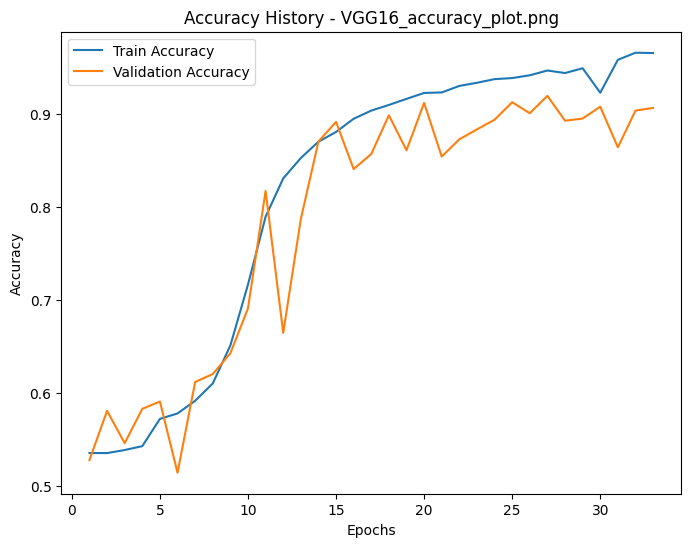

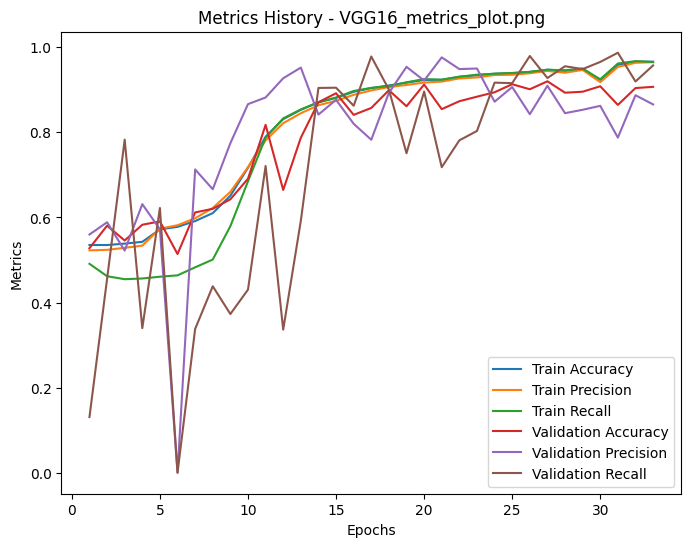

In [14]:
# Experiment ID:BMS-0005
experimentId = "BMS-0005"

# Load Directories (Leave alone unless specifying a different dataset)
experiment_train_directory = train_directory
experiment_test_directory = test_directory
experiment_directory = f"{experiment_base_directory}/{experimentId}"
experiment_results_directory = f"{experiment_directory}/results"
experiment_models_directory = f"{experiment_directory}/models"
experiment_load_model_directory = "../experiments/base-model-selection/BMS-0001/models"

# Create directories if they don't exist
os.makedirs(name=experiment_directory, exist_ok=True)
os.makedirs(name=experiment_models_directory, exist_ok=True)
os.makedirs(name=experiment_results_directory, exist_ok=True)

# Declare lists for report generation
accuracy_report = []

# Declare Test Configurations
test_configurations = [
    [VGG16, vgg16_preprocess_input, 16, True],
]

# Declare accuracy_test list
accuracy_test = []

# Define Early Stopping Callback
early_stopping = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=8
)

# Define Reduce Learning Rate on Plateau Callback
lr_reducer = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    verbose=1,
)

# Loop through all combinations of models and trainable layers
for pretrained_model, preprocessing_function, batch_size, is_augmented in test_configurations:
    # Clear Session
    K.clear_session()
    
    # Setup Model Check Pointing
    
    nameSuffix = 'augmented' if is_augmented == True else 'not_augmented'
    model_checkpoint_vl = ModelCheckpoint(
        filepath=f"{experiment_models_directory}/{pretrained_model.__name__}_model_{nameSuffix}_vl.h5",
        monitor='val_loss',
        mode='min',
        verbose=1,
        save_best_only=True
    )
    
    model_checkpoint_ba = ModelCheckpoint(
        filepath=f"{experiment_models_directory}/{pretrained_model.__name__}_model_{nameSuffix}_ba.h5",
        monitor='val_binary_accuracy',
        mode='max',
        verbose=1,
        save_best_only=True
    )
    
    # Create a dataset and preprocess images to suit base model
    train_ds, val_ds = create_train_val_datasets(preprocessing_function, experiment_train_directory, batch_size=batch_size, augment_data=is_augmented)
    test_ds = create_test_dataset(preprocessing_function, experiment_test_directory, batch_size=batch_size)

    # Create Input Layer
    inputs = Input(shape=(299, 299, 3))


    #####################################################################################################################################
    # Load Previous Model and Weights
    #####################################################################################################################################

    # Load Model
    model = keras.models.load_model(
        f"{experiment_load_model_directory}/{pretrained_model.__name__}_model_{nameSuffix}.h5",
    )
    
    # Create Input Layer
    inputs = Input(shape=(299, 299, 3))

    # Base model is the second layer in the model
    base_model = model.layers[1]

    # Make Base Model Trainable
    base_model.trainable = True

    # Freeze the base model (do not train everything but last 15 layers)
    for layer in base_model.layers[:-15]:
        layer.trainable = False

    # Hookup Previous Model Layers to New Model
    inputs = keras.Input(shape=(299, 299, 3))
    x = base_model(inputs, training=False)
    
    # Traverse the layers and connect them
    for layer in model.layers[2:]:
        x = layer(x)
    
    # Define the model
    model = keras.Model(inputs=inputs, outputs=x)

    model.summary()
    # Compile the model
    model.compile(
        optimizer=Adam(1e-4),  
        loss=BinaryCrossentropy(from_logits=False),
        metrics=[BinaryAccuracy(), Precision(), Recall(), AUC()]
    )
    
    #####################################################################################################################################
    # Begin Fine Tuning Entire Model
    #####################################################################################################################################
    
    # Start Timer to measure processing time 
    start_time = time.time()

    # Train the model
    history = model.fit(
        train_ds, 
        steps_per_epoch=train_ds.samples // train_ds.batch_size,
        epochs=50, 
        validation_data=test_ds,
        validation_steps=test_ds.samples // test_ds.batch_size,
        callbacks = [early_stopping, lr_reducer, model_checkpoint_vl, model_checkpoint_ba]
    )
    
    # End Timer and calculate processing time
    end_time = time.time()
    processing_time = end_time - start_time

    # Evaluate the model
    evaluate = model.evaluate(test_ds, steps = test_ds.samples // test_ds.batch_size, verbose=1)

    # Append results to accuracy_test list
    history_key = list(history.history.keys()) # As names of metric names can be dynamic, we need to get the keys of the history object
    accuracy_test.append({
        'Base Model': pretrained_model.__name__,
        'duration': round(processing_time, 3),
        'test_accuracy': round(evaluate[1], 3),
        'test_precision': round(evaluate[2], 3),
        'test_recall': round(evaluate[3], 3),
        'test_loss': round(evaluate[0], 3),
        'train_accuracy': round(history.history[history_key[1]][-1],3),
        'train_precision': round(history.history[history_key[2]][-1],3),
        'train_recall': round(history.history[history_key[3]][-1],3),
        'train_auc' : round(history.history[history_key[4]][-1],3),
        'train_loss': round(history.history[history_key[0]][-1],3),
        'val_accuracy': round(history.history[history_key[6]][-1],3),
        'val_precision': round(history.history[history_key[7]][-1],3),
        'val_recall': round(history.history[history_key[8]][-1],3),
        'val_auc' : round(history.history[history_key[9]][-1],3),
        'val_loss': round(history.history[history_key[5]][-1],3)
    })
    
    epochs_report = pd.DataFrame(history.history)
    epochs_report.to_csv(f"{experiment_results_directory}/{pretrained_model.__name__}_epochs_report.csv", index=False)
    
    model.save(f"{experiment_models_directory}/{pretrained_model.__name__}_finetuned_model_{nameSuffix}.h5")

# Create DataFrame with accuracy score and export as .csv
accuracy_test_results = pd.DataFrame(accuracy_test)
accuracy_test_results.to_csv(f'{experiment_results_directory}/accuracy_test_results.csv', index=False)

# Generate graphs from epochs_reports.csv and output to results folder.
create_accuracy_plots(f"{experiment_results_directory}")
create_all_metrics_plots(f"{experiment_results_directory}")

----
## Experiment #BMS-0006 | VGG19 Fine-Tuning
**Experiment ID:** #BMS-0006  
**Experiment Description:**  Continuation of experiment BMS-0001, We load the pretrained models from the previous experiment and unfreeze the last 15 layers of the base model. The experiment we use VGG19 with data augmentation enabled.


Found 38634 images belonging to 2 classes.
Found 9657 images belonging to 2 classes.
Found 8557 images belonging to 2 classes.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 9, 9, 512)         20024384  
                                                                 
 conv2d (Conv2D)             (None, 9, 9, 2048)        9439232   
                                                                 
 batch_normalization (BatchN  (None, 9, 9, 2048)       8192      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 9, 9, 2048)        0         
                                                                 


2023-06-02 18:31:09.681301: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-02 18:31:14.564406: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.16GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


4829/4829 [==============================] - ETA: 0s - loss: 0.7184 - binary_accuracy: 0.5185 - precision: 0.5044 - recall: 0.4464 - auc: 0.5243

2023-06-02 18:40:30.614667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.74412, saving model to ../experiments/base-model-selection/BMS-0006/models/VGG19_model_augmented_vl.h5

Epoch 1: val_binary_accuracy improved from -inf to 0.48340, saving model to ../experiments/base-model-selection/BMS-0006/models/VGG19_model_augmented_ba.h5
4829/4829 [==============================] - 618s 127ms/step - loss: 0.7184 - binary_accuracy: 0.5185 - precision: 0.5044 - recall: 0.4464 - auc: 0.5243 - val_loss: 0.7441 - val_binary_accuracy: 0.4834 - val_precision: 0.4844 - val_recall: 0.9771 - val_auc: 0.5188 - lr: 1.0000e-04
Epoch 2/50
4829/4829 [==============================] - ETA: 0s - loss: 0.7077 - binary_accuracy: 0.5036 - precision: 0.4865 - recall: 0.4109 - auc: 0.5000
Epoch 2: val_loss improved from 0.74412 to 0.69329, saving model to ../experiments/base-model-selection/BMS-0006/models/VGG19_model_augmented_vl.h5

Epoch 2: val_binary_accuracy improved from 0.48340 to 0.52081, saving model to ../experiments/base-model-select

2023-06-03 02:38:04.325750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1069/1069 [==============================] - 56s 53ms/step - loss: 0.2651 - binary_accuracy: 0.9069 - precision: 0.8669 - recall: 0.9553 - auc: 0.9737


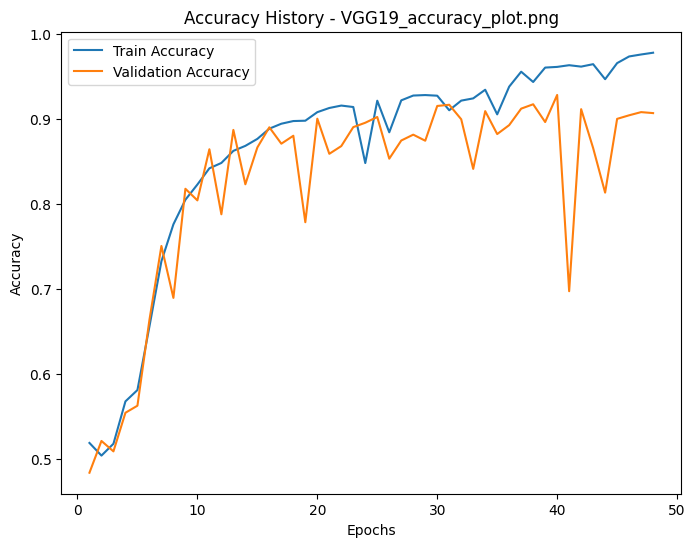

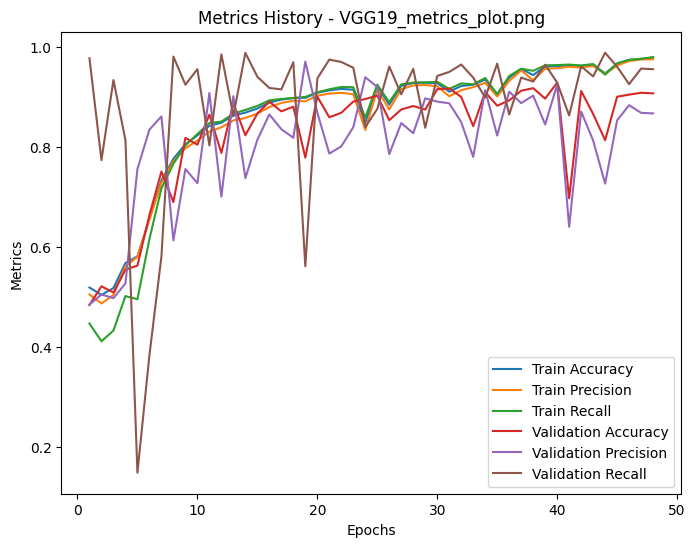

In [6]:
# Experiment ID:BMS-0006
experimentId = "BMS-0006"

# Load Directories (Leave alone unless specifying a different dataset)
experiment_train_directory = train_directory
experiment_test_directory = test_directory
experiment_directory = f"{experiment_base_directory}/{experimentId}"
experiment_results_directory = f"{experiment_directory}/results"
experiment_models_directory = f"{experiment_directory}/models"
experiment_load_model_directory = "../experiments/base-model-selection/BMS-0001/models"

# Create directories if they don't exist
os.makedirs(name=experiment_directory, exist_ok=True)
os.makedirs(name=experiment_models_directory, exist_ok=True)
os.makedirs(name=experiment_results_directory, exist_ok=True)

# Declare lists for report generation
accuracy_report = []

# Declare Test Configurations
test_configurations = [
    [VGG19, vgg19_preprocess_input, 8, True],
]

# Declare accuracy_test list
accuracy_test = []

# Define Early Stopping Callback
early_stopping = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=8
)

# Define Reduce Learning Rate on Plateau Callback
lr_reducer = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    verbose=1,
)

# Loop through all combinations of models and trainable layers
for pretrained_model, preprocessing_function, batch_size, is_augmented in test_configurations:
    # Clear Session
    K.clear_session()
    
    # Setup Model Check Pointing
    
    nameSuffix = 'augmented' if is_augmented == True else 'not_augmented'
    model_checkpoint_vl = ModelCheckpoint(
        filepath=f"{experiment_models_directory}/{pretrained_model.__name__}_model_{nameSuffix}_vl.h5",
        monitor='val_loss',
        mode='min',
        verbose=1,
        save_best_only=True
    )
    
    model_checkpoint_ba = ModelCheckpoint(
        filepath=f"{experiment_models_directory}/{pretrained_model.__name__}_model_{nameSuffix}_ba.h5",
        monitor='val_binary_accuracy',
        mode='max',
        verbose=1,
        save_best_only=True
    )
    
    # Create a dataset and preprocess images to suit base model
    train_ds, val_ds = create_train_val_datasets(preprocessing_function, experiment_train_directory, batch_size=batch_size, augment_data=is_augmented)
    test_ds = create_test_dataset(preprocessing_function, experiment_test_directory, batch_size=batch_size)

    # Create Input Layer
    inputs = Input(shape=(299, 299, 3))


    #####################################################################################################################################
    # Load Previous Model and Weights
    #####################################################################################################################################

    # Load Model
    model = keras.models.load_model(
        f"{experiment_load_model_directory}/{pretrained_model.__name__}_model_{nameSuffix}.h5",
    )
    
    # Create Input Layer
    inputs = Input(shape=(299, 299, 3))

    # Base model is the second layer in the model
    base_model = model.layers[1]

    # Make Base Model Trainable
    base_model.trainable = True

    # Freeze the base model (do not train everything but last 15 layers)
    for layer in base_model.layers[:-15]:
        layer.trainable = False

    # Hookup Previous Model Layers to New Model
    inputs = keras.Input(shape=(299, 299, 3))
    x = base_model(inputs, training=False)
    
    # Traverse the layers and connect them
    for layer in model.layers[2:]:
        x = layer(x)
    
    # Define the model
    model = keras.Model(inputs=inputs, outputs=x)

    model.summary()
    # Compile the model
    model.compile(
        optimizer=Adam(1e-4),  
        loss=BinaryCrossentropy(from_logits=False),
        metrics=[BinaryAccuracy(), Precision(), Recall(), AUC()]
    )
    
    #####################################################################################################################################
    # Begin Fine Tuning Entire Model
    #####################################################################################################################################
    
    # Start Timer to measure processing time 
    start_time = time.time()

    # Train the model
    history = model.fit(
        train_ds, 
        steps_per_epoch=train_ds.samples // train_ds.batch_size,
        epochs=50, 
        validation_data=test_ds,
        validation_steps=test_ds.samples // test_ds.batch_size,
        callbacks = [early_stopping, lr_reducer, model_checkpoint_vl, model_checkpoint_ba]
    )
    
    # End Timer and calculate processing time
    end_time = time.time()
    processing_time = end_time - start_time

    # Evaluate the model
    evaluate = model.evaluate(test_ds, steps = test_ds.samples // test_ds.batch_size, verbose=1)

    # Append results to accuracy_test list
    history_key = list(history.history.keys()) # As names of metric names can be dynamic, we need to get the keys of the history object
    accuracy_test.append({
        'Base Model': pretrained_model.__name__,
        'duration': round(processing_time, 3),
        'test_accuracy': round(evaluate[1], 3),
        'test_precision': round(evaluate[2], 3),
        'test_recall': round(evaluate[3], 3),
        'test_loss': round(evaluate[0], 3),
        'train_accuracy': round(history.history[history_key[1]][-1],3),
        'train_precision': round(history.history[history_key[2]][-1],3),
        'train_recall': round(history.history[history_key[3]][-1],3),
        'train_auc' : round(history.history[history_key[4]][-1],3),
        'train_loss': round(history.history[history_key[0]][-1],3),
        'val_accuracy': round(history.history[history_key[6]][-1],3),
        'val_precision': round(history.history[history_key[7]][-1],3),
        'val_recall': round(history.history[history_key[8]][-1],3),
        'val_auc' : round(history.history[history_key[9]][-1],3),
        'val_loss': round(history.history[history_key[5]][-1],3)
    })
    
    epochs_report = pd.DataFrame(history.history)
    epochs_report.to_csv(f"{experiment_results_directory}/{pretrained_model.__name__}_epochs_report.csv", index=False)
    
    model.save(f"{experiment_models_directory}/{pretrained_model.__name__}_finetuned_model_{nameSuffix}.h5")

# Create DataFrame with accuracy score and export as .csv
accuracy_test_results = pd.DataFrame(accuracy_test)
accuracy_test_results.to_csv(f'{experiment_results_directory}/accuracy_test_results.csv', index=False)

# Generate graphs from epochs_reports.csv and output to results folder.
create_accuracy_plots(f"{experiment_results_directory}")
create_all_metrics_plots(f"{experiment_results_directory}")